In [2]:

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import tensorflow as tf 
import tensorboard as tb 
#tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import timeit
import datetime as dt
import utilities as ut
#from darts import TimeSeries
#import holidays
import warnings
#from prophet import Prophet
#from prophet.plot import add_changepoints_to_plot
#from darts.dataprocessing.transformers import (
#    Scaler,
#    MissingValuesFiller,
#    Mapper,
#    InvertibleMapper,
#)
import os



warnings.filterwarnings("ignore") 


from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


#data1=pd.read_csv('true_eph.csv',sep=',',index_col=0)
#data1 = data1.iloc[:15000]

In [275]:
data1 = pd.read_csv('example_ob.csv',sep=',',index_col=0)
data1["linear"] = np.arange(len(data1))
data1['group'] = 1 # fake group

In [276]:
data1

,x,y,z,time,linear,group
0,580097.336,-819477.269,6971833.474,2021-12-31 23:42:00,0,1
1,-556348.107,-1566013.669,6845379.446,2021-12-31 23:45:00,1,1
2,-1690951.773,-2225602.384,6467359.447,2021-12-31 23:48:00,2,1
3,-2779724.029,-2774795.453,5851637.160,2021-12-31 23:51:00,3,1
4,-3779783.815,-3195305.020,5020812.365,2021-12-31 23:54:00,4,1
...,...,...,...,...,...,...
14995,3481021.718,-5110544.473,3391538.748,2022-02-01 05:27:00,14995,1
14996,2815727.051,-4648795.150,4493129.967,2022-02-01 05:30:00,14996,1
14997,2062265.212,-3998757.064,5429555.452,2022-02-01 05:33:00,14997,1
14998,1252869.769,-3182417.875,6166605.081,2022-02-01 05:36:00,14998,1


In [4]:
max_prediction_length = 60
max_encoder_length = 30
train_pd = data1.iloc[:-3000]
#train_pd_fill = ut.filler_with_prophet(train_pd)
training = TimeSeriesDataSet(
   train_pd,
    time_idx="linear",
    target=["x",
            "y",
            "z"],
    group_ids=["group"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
  #  static_categoricals=["ars"],
  #  static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
  #  time_varying_known_categoricals=["weekend", "month","pt_holydays"],
 #   variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["linear"],
    time_varying_unknown_categoricals=[],
    #time_varying_unknown_reals=[
    #    "y",
    #    "z"
    #],
  # target_normalizer=GroupNormalizer(
   #     groups=["agency", "sku"], transformation="softplus"
  #  ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,
)

validation = TimeSeriesDataSet.from_dataset(training, train_pd.append(data1.iloc[-3000:-1000]), predict=True, stop_randomization=True)


batch_size = 300  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [42]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=32,
                                    verbose=False, mode="min",stopping_threshold = 47)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard
#mcp = ModelCheckpoint(monitor='val_MAPE', auto_insert_metric_name=True)
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    weights_summary="top",
    gradient_clip_val= 0.22730,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    enable_progress_bar=True,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.095,
    hidden_size=10,
    attention_head_size= 5,
    dropout=0.05,
    hidden_continuous_size=11,
    output_size=[7,7,7],  # 7 quantiles by default
    loss=QuantileLoss(),
   # log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
#%%

# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MultiLoss                       | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 198   
4  | static_variable_selection          | VariableSelectionNetwork        | 4.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 460   
8  | static_context_initial_hidden_lstm | GatedResid

Number of parameters in network: 12.5k


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [43]:
trainer.logged_metrics

{'train_loss_step': 2931559.5,
 'val_loss': 2077828.0,
 'x val_SMAPE': 0.20486195385456085,
 'y val_SMAPE': 0.3160545229911804,
 'z val_SMAPE': 1.907223105430603,
 'x val_MAE': 353913.0,
 'y val_MAE': 247874.640625,
 'z val_MAE': 4336251.0,
 'x val_RMSE': 419890.5,
 'y val_RMSE': 320082.5625,
 'z val_RMSE': 4863316.5,
 'x val_MAPE': 0.25922390818595886,
 'y val_MAPE': 0.38851824402809143,
 'z val_MAPE': 1.0786685943603516,
 'train_loss_epoch': 2916634.25}

<Figure size 6000x3000 with 0 Axes>

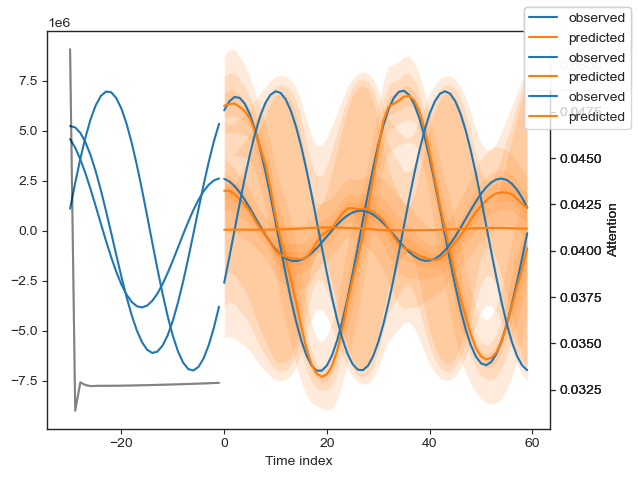

In [269]:
new_raw_predictions, new_x = best_tft.predict(val_dataloader,mode='raw', return_x=True)


sns.set_style('ticks', {'legend.frameon':True})
fig =plt.figure(1,figsize=(10,5),dpi=600)
m =best_tft.plot_prediction(new_x, new_raw_predictions,idx=0, show_future_observed=True,add_loss_to_title=False,);
  #  m.xaxis.set_xticklabels(new_data.time.unique())
    #plt.legend()
   # plt.tight_layout()
    #plt.savefig('plots/predictions_00000'+str(idx)+'.pdf')

In [166]:
encoder_target = torch.stack(new_x['encoder_target']).detach().cpu().numpy()
decoder_target = torch.stack(new_x['decoder_target']).detach().cpu().numpy()
y_all = np.concatenate((encoder_target,decoder_target),axis=2)


In [262]:
#não é preciso estar hardcoded
n_pred = 60 # n de previsoes
n_obs = 30
x_obs = np.arange(-n_obs, 0) 
x_pred = np.arange(n_pred)
prop_cycle = iter(plt.rcParams["axes.prop_cycle"]) #colors, irrelevant
obs_color = next(prop_cycle)["color"]
pred_color = next(prop_cycle)["color"]
plot_attention = True
var_idx=1  # this identifies the variable being plotted, change at will

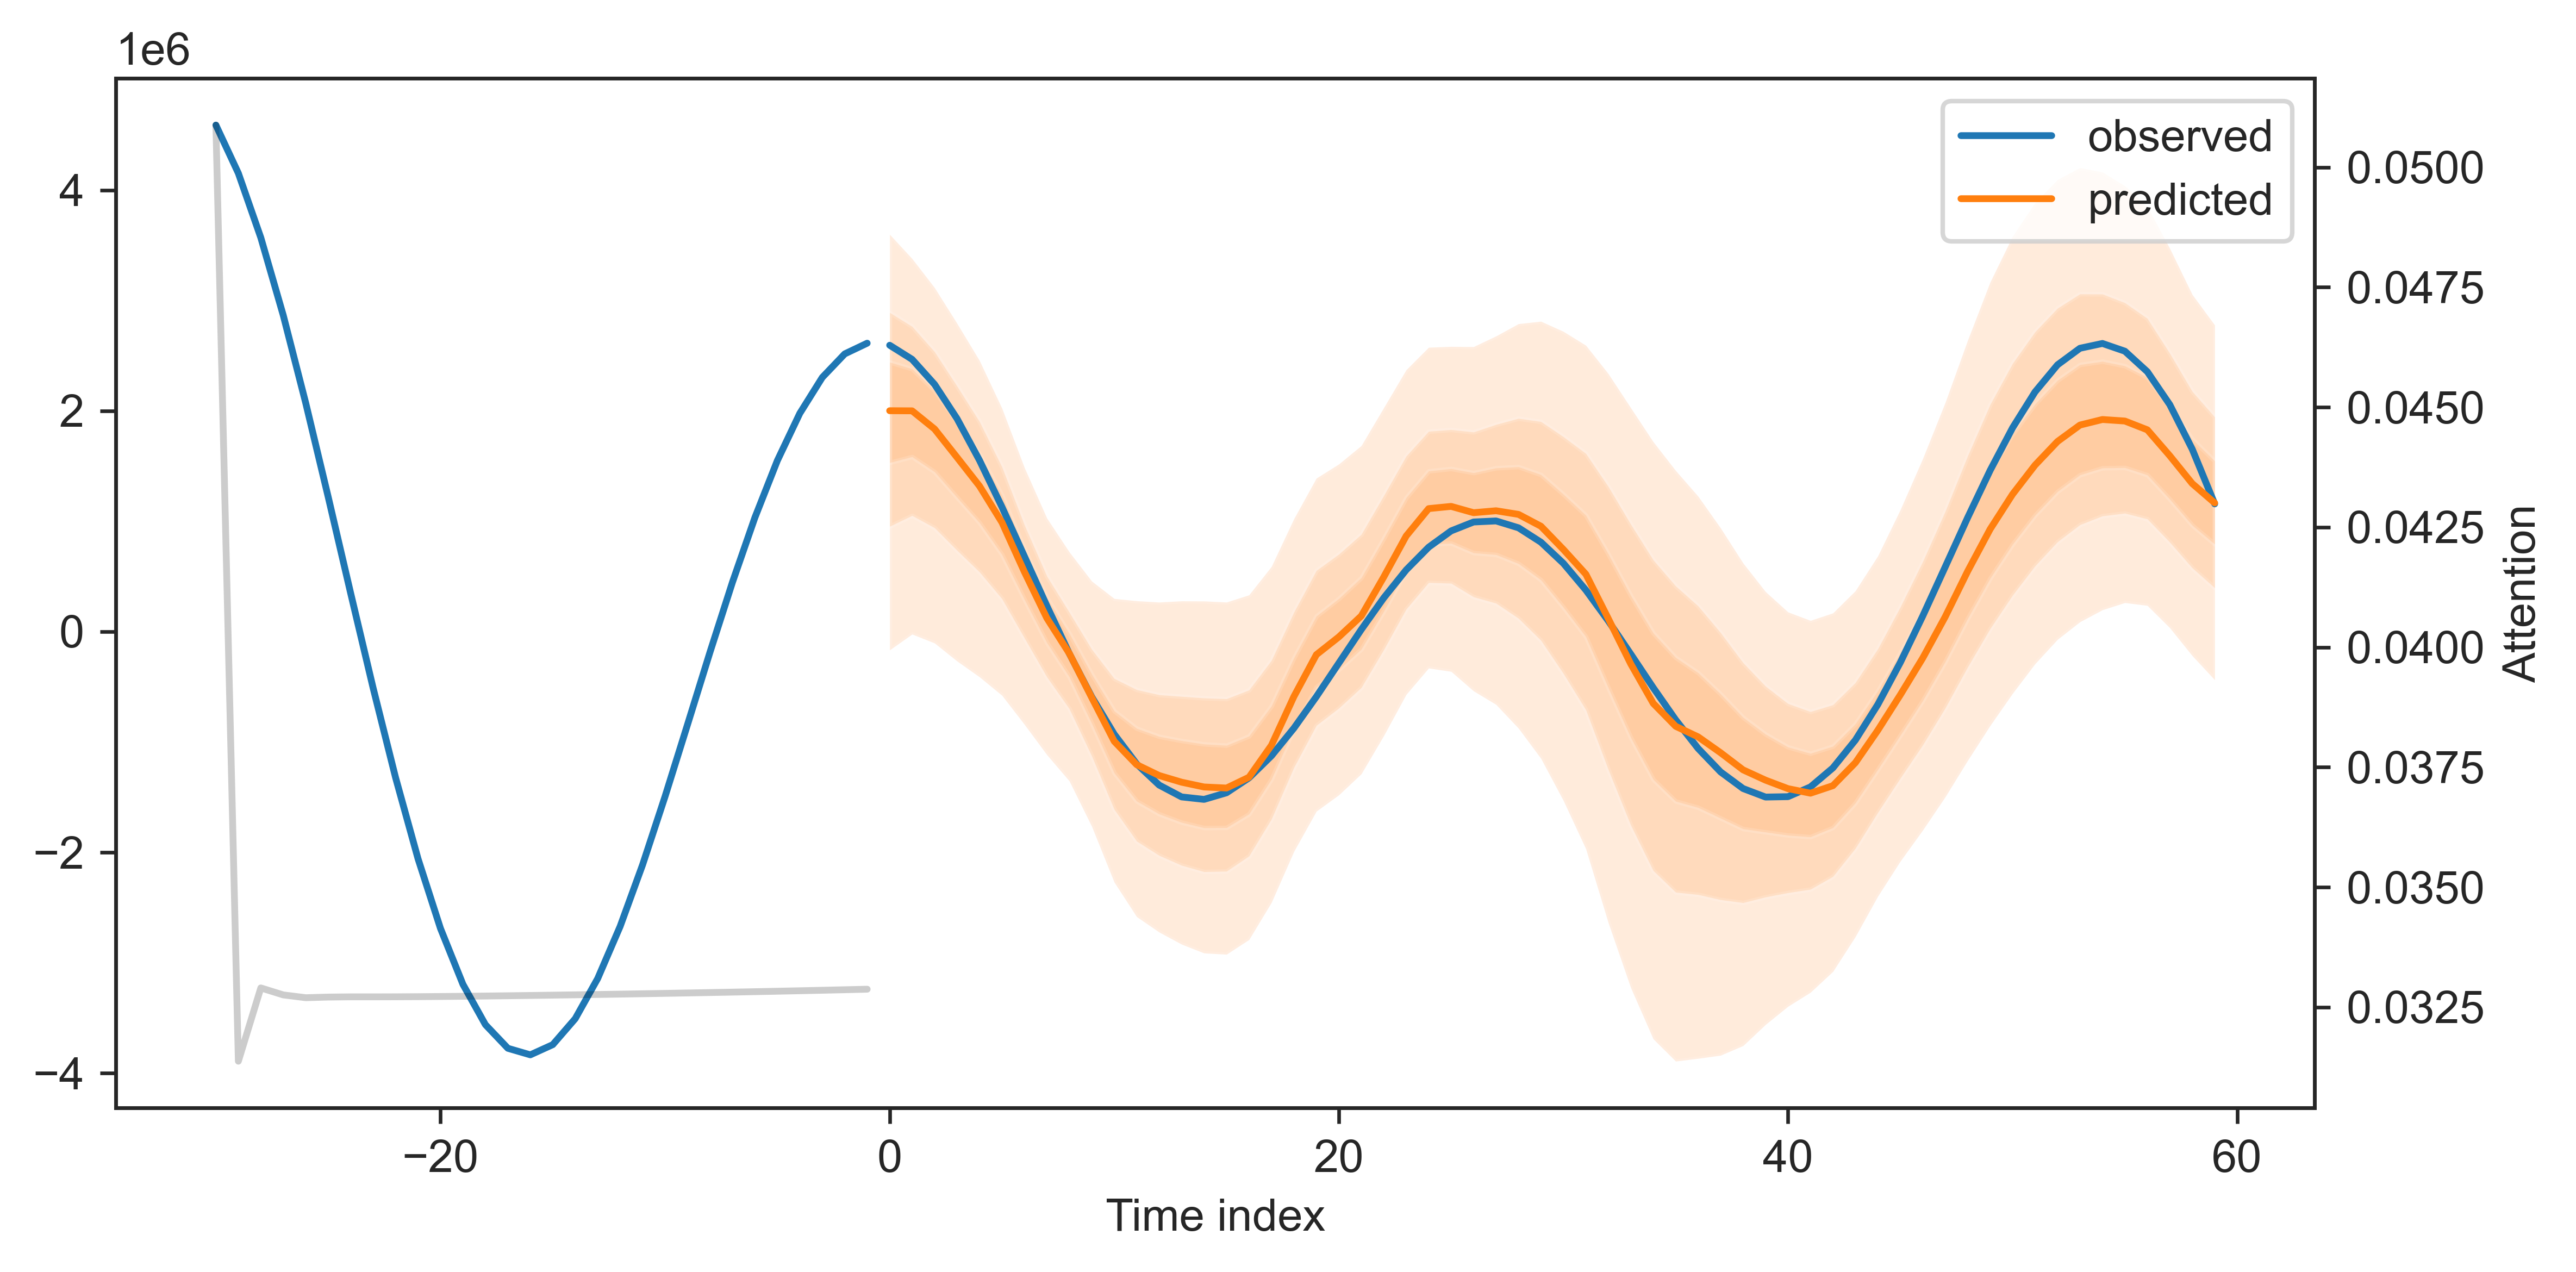

In [267]:
fig=plt.figure(1,figsize=(8,4),dpi=600)
ax = plt.gca()

y_raw = new_raw_predictions.prediction[var_idx].detach().cpu().numpy()
y_quantile_number = np.shape(y_raw)[2]
ax.plot(x_obs, y_all[var_idx][0][:30], label="observed", c=obs_color)
ax.plot(x_pred, y_all[var_idx][0][-60:], c=obs_color)
ax.plot(x_pred,y_raw[0,:,y_quantile_number // 2],label='predicted',c=pred_color)
for i in range(y_quantile_number // 2):
                if len(x_pred) > 1:
                    ax.fill_between(x_pred, y_raw[0,:, i], y_raw[0,:, -i - 1], alpha=0.15, fc=pred_color)
                
if plot_attention:
            interpretation = best_tft.interpret_output(new_raw_predictions, reduction="sum")
            ax2 = ax.twinx()
            ax2.set_ylabel("Attention")
            encoder_length = x["encoder_lengths"][0]
            ax2.plot(
                np.arange(-n_obs, 0),
                interpretation["attention"].detach().cpu(),
                alpha=0.2,
                color="k",
            )             
                
ax.set_xlabel("Time index")
ax.legend()
fig.tight_layout()
plt.show()


In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=30,
    gradient_clip_val_range=(0.001, 0.2),
    hidden_size_range=(8,50),
    hidden_continuous_size_range=(8, 60),
    attention_head_size_range=(4, 30),
    learning_rate_range=(0.0001, 0.01),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=True,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-02-28 01:45:12,261] A new study created in memory with name: no-name-4cd3fecf-104a-4aa4-b709-75bbf0212f22
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x375 with 1 Axes>,
 'encoder_variables': <Figure size 700x250 with 1 Axes>,
 'decoder_variables': <Figure size 700x250 with 1 Axes>}

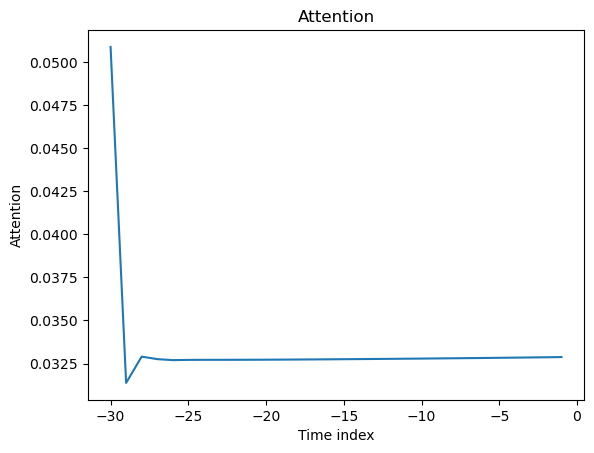

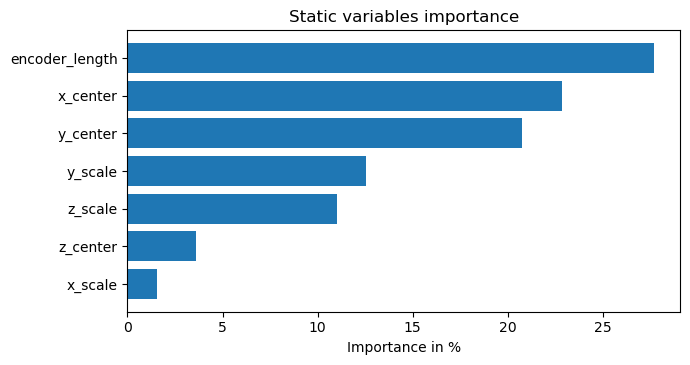

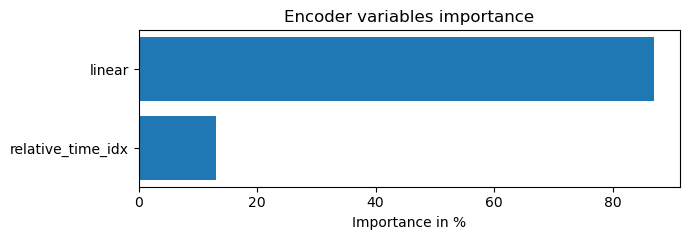

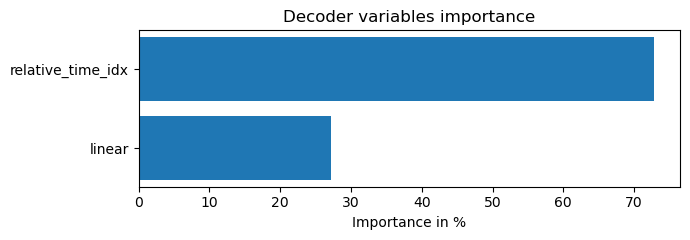

In [57]:
predictions, new_x = best_tft.predict(val_dataloader,mode='raw', return_x=True)
interpretation = best_tft.interpret_output(predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

Text(0, 0.5, 'Attention')

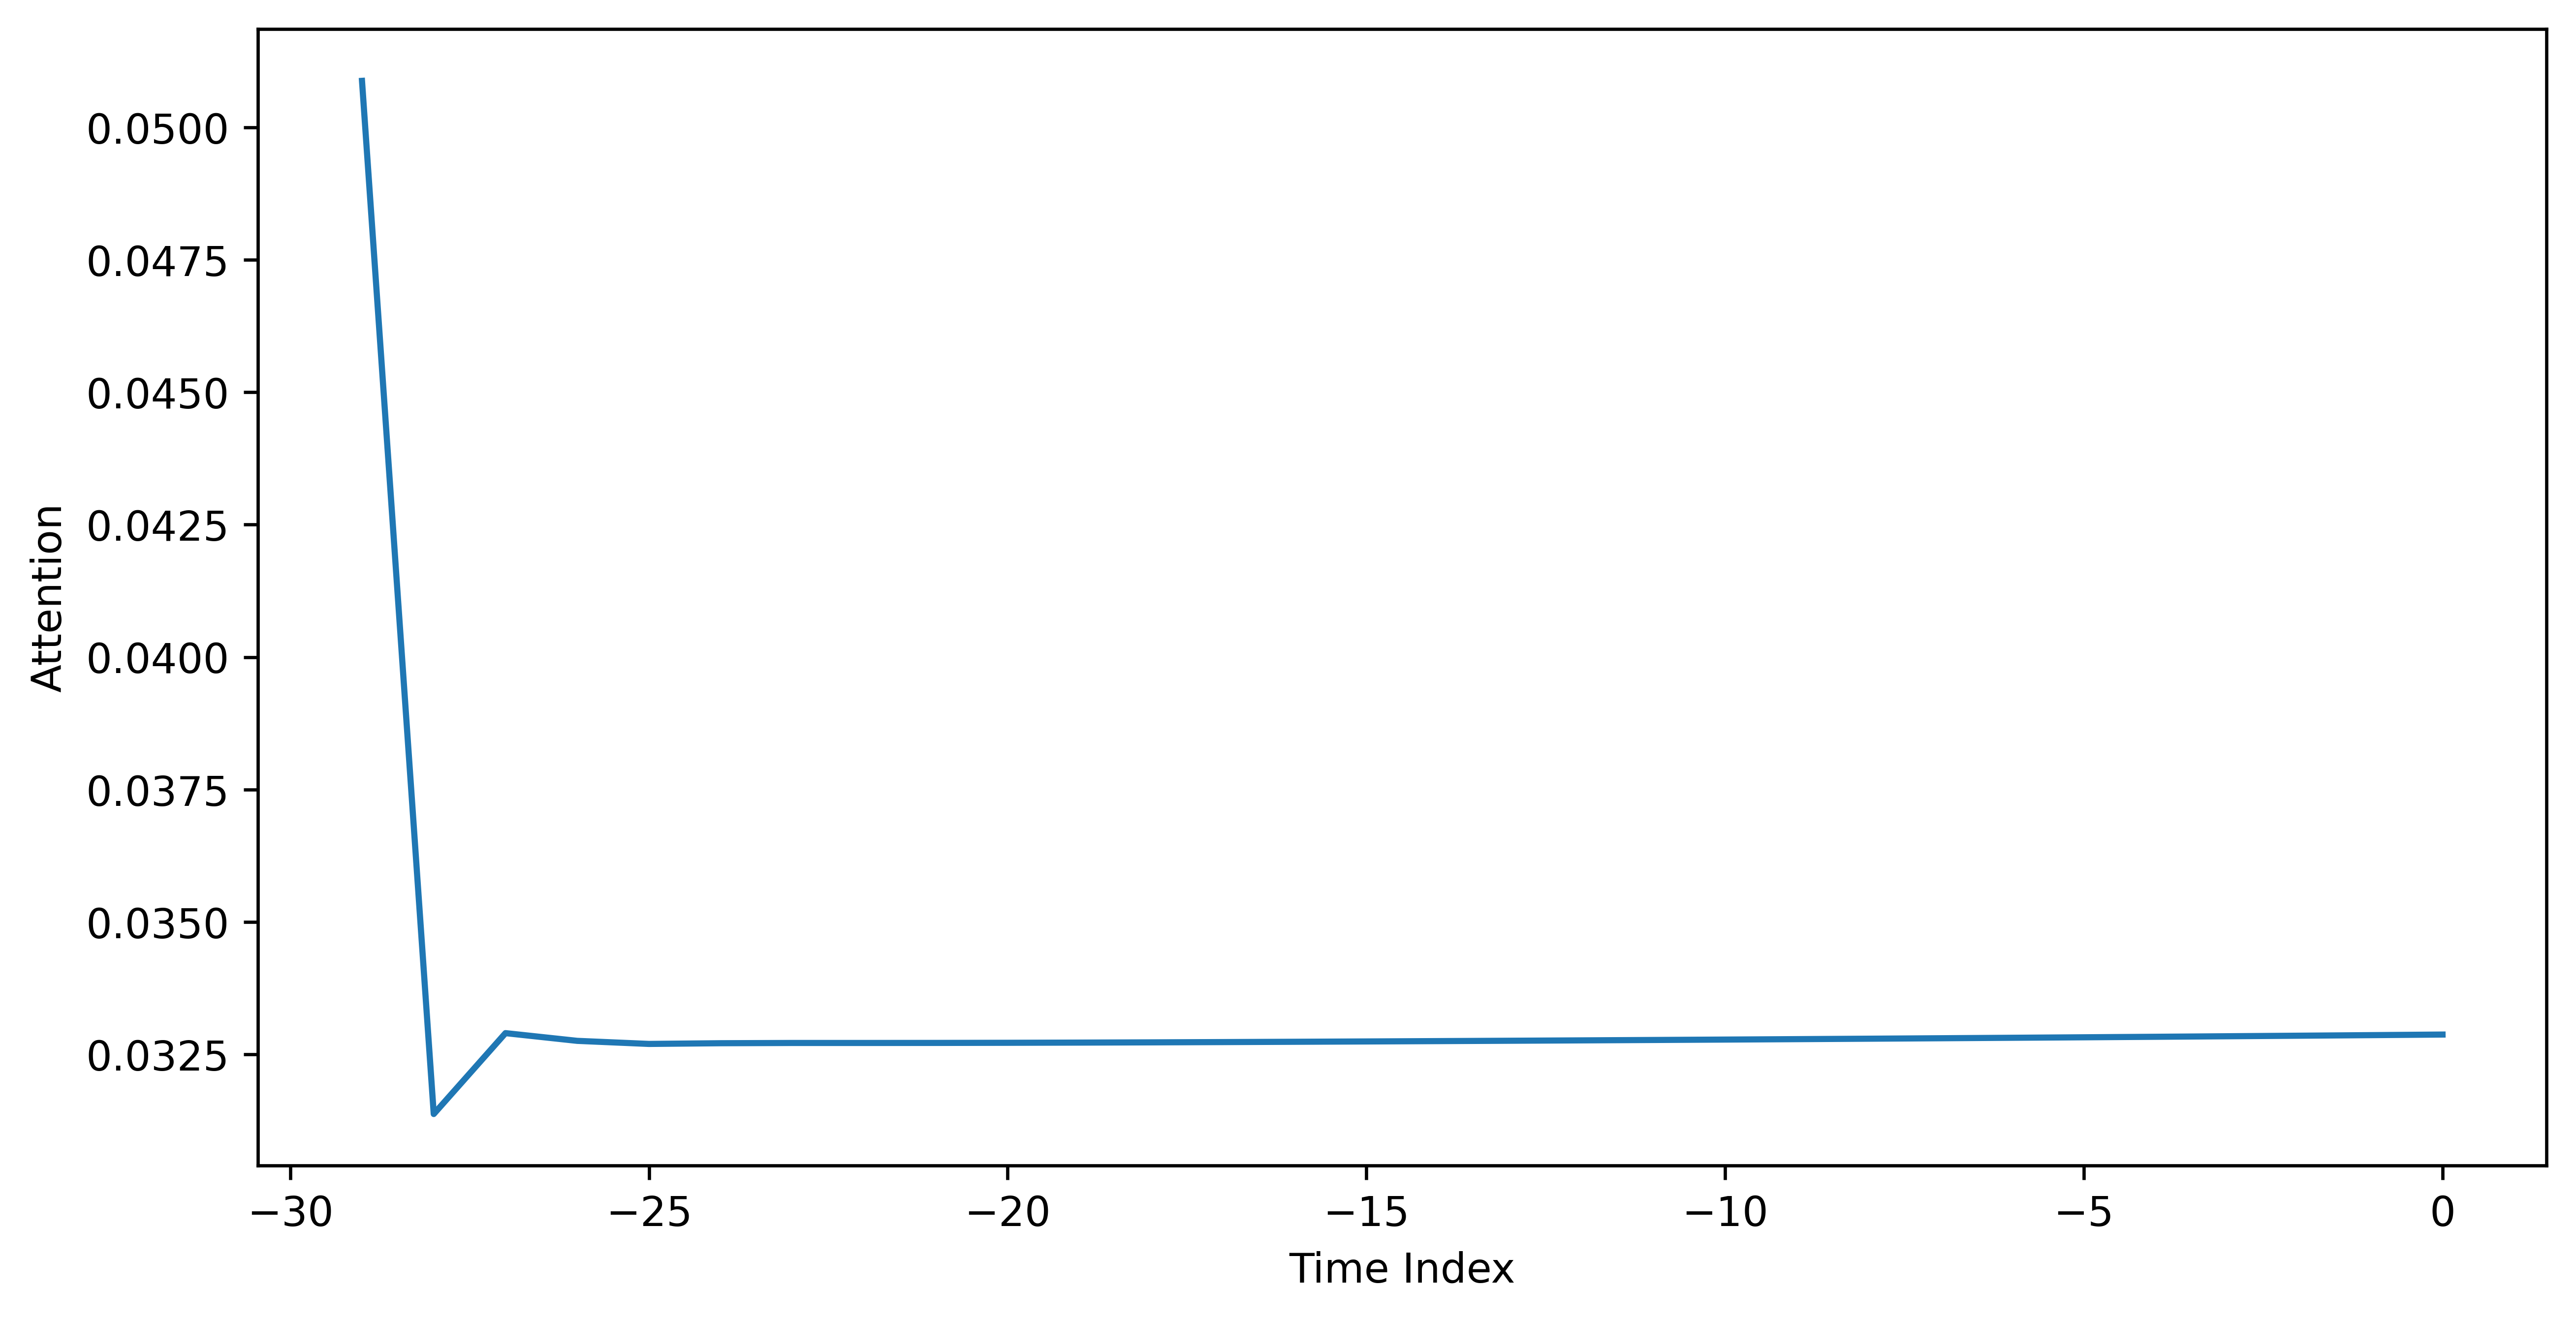

In [71]:
fig =plt.figure(1,figsize=(10,5),dpi=600)

predictions33, new_x33 = best_tft.predict(val_dataloader,mode='raw', return_x=True)
interpretation3 = best_tft.interpret_output(predictions33, reduction="sum")
intp=interpretation['attention'].detach().cpu()


#intp1= intp / intp.sum(-1).unsqueeze(-1) #normalize

sns.lineplot(x=-np.sort(np.arange(0,30))[::-1],y=intp1)
plt.xlabel('Time Index')
plt.ylabel("Attention")

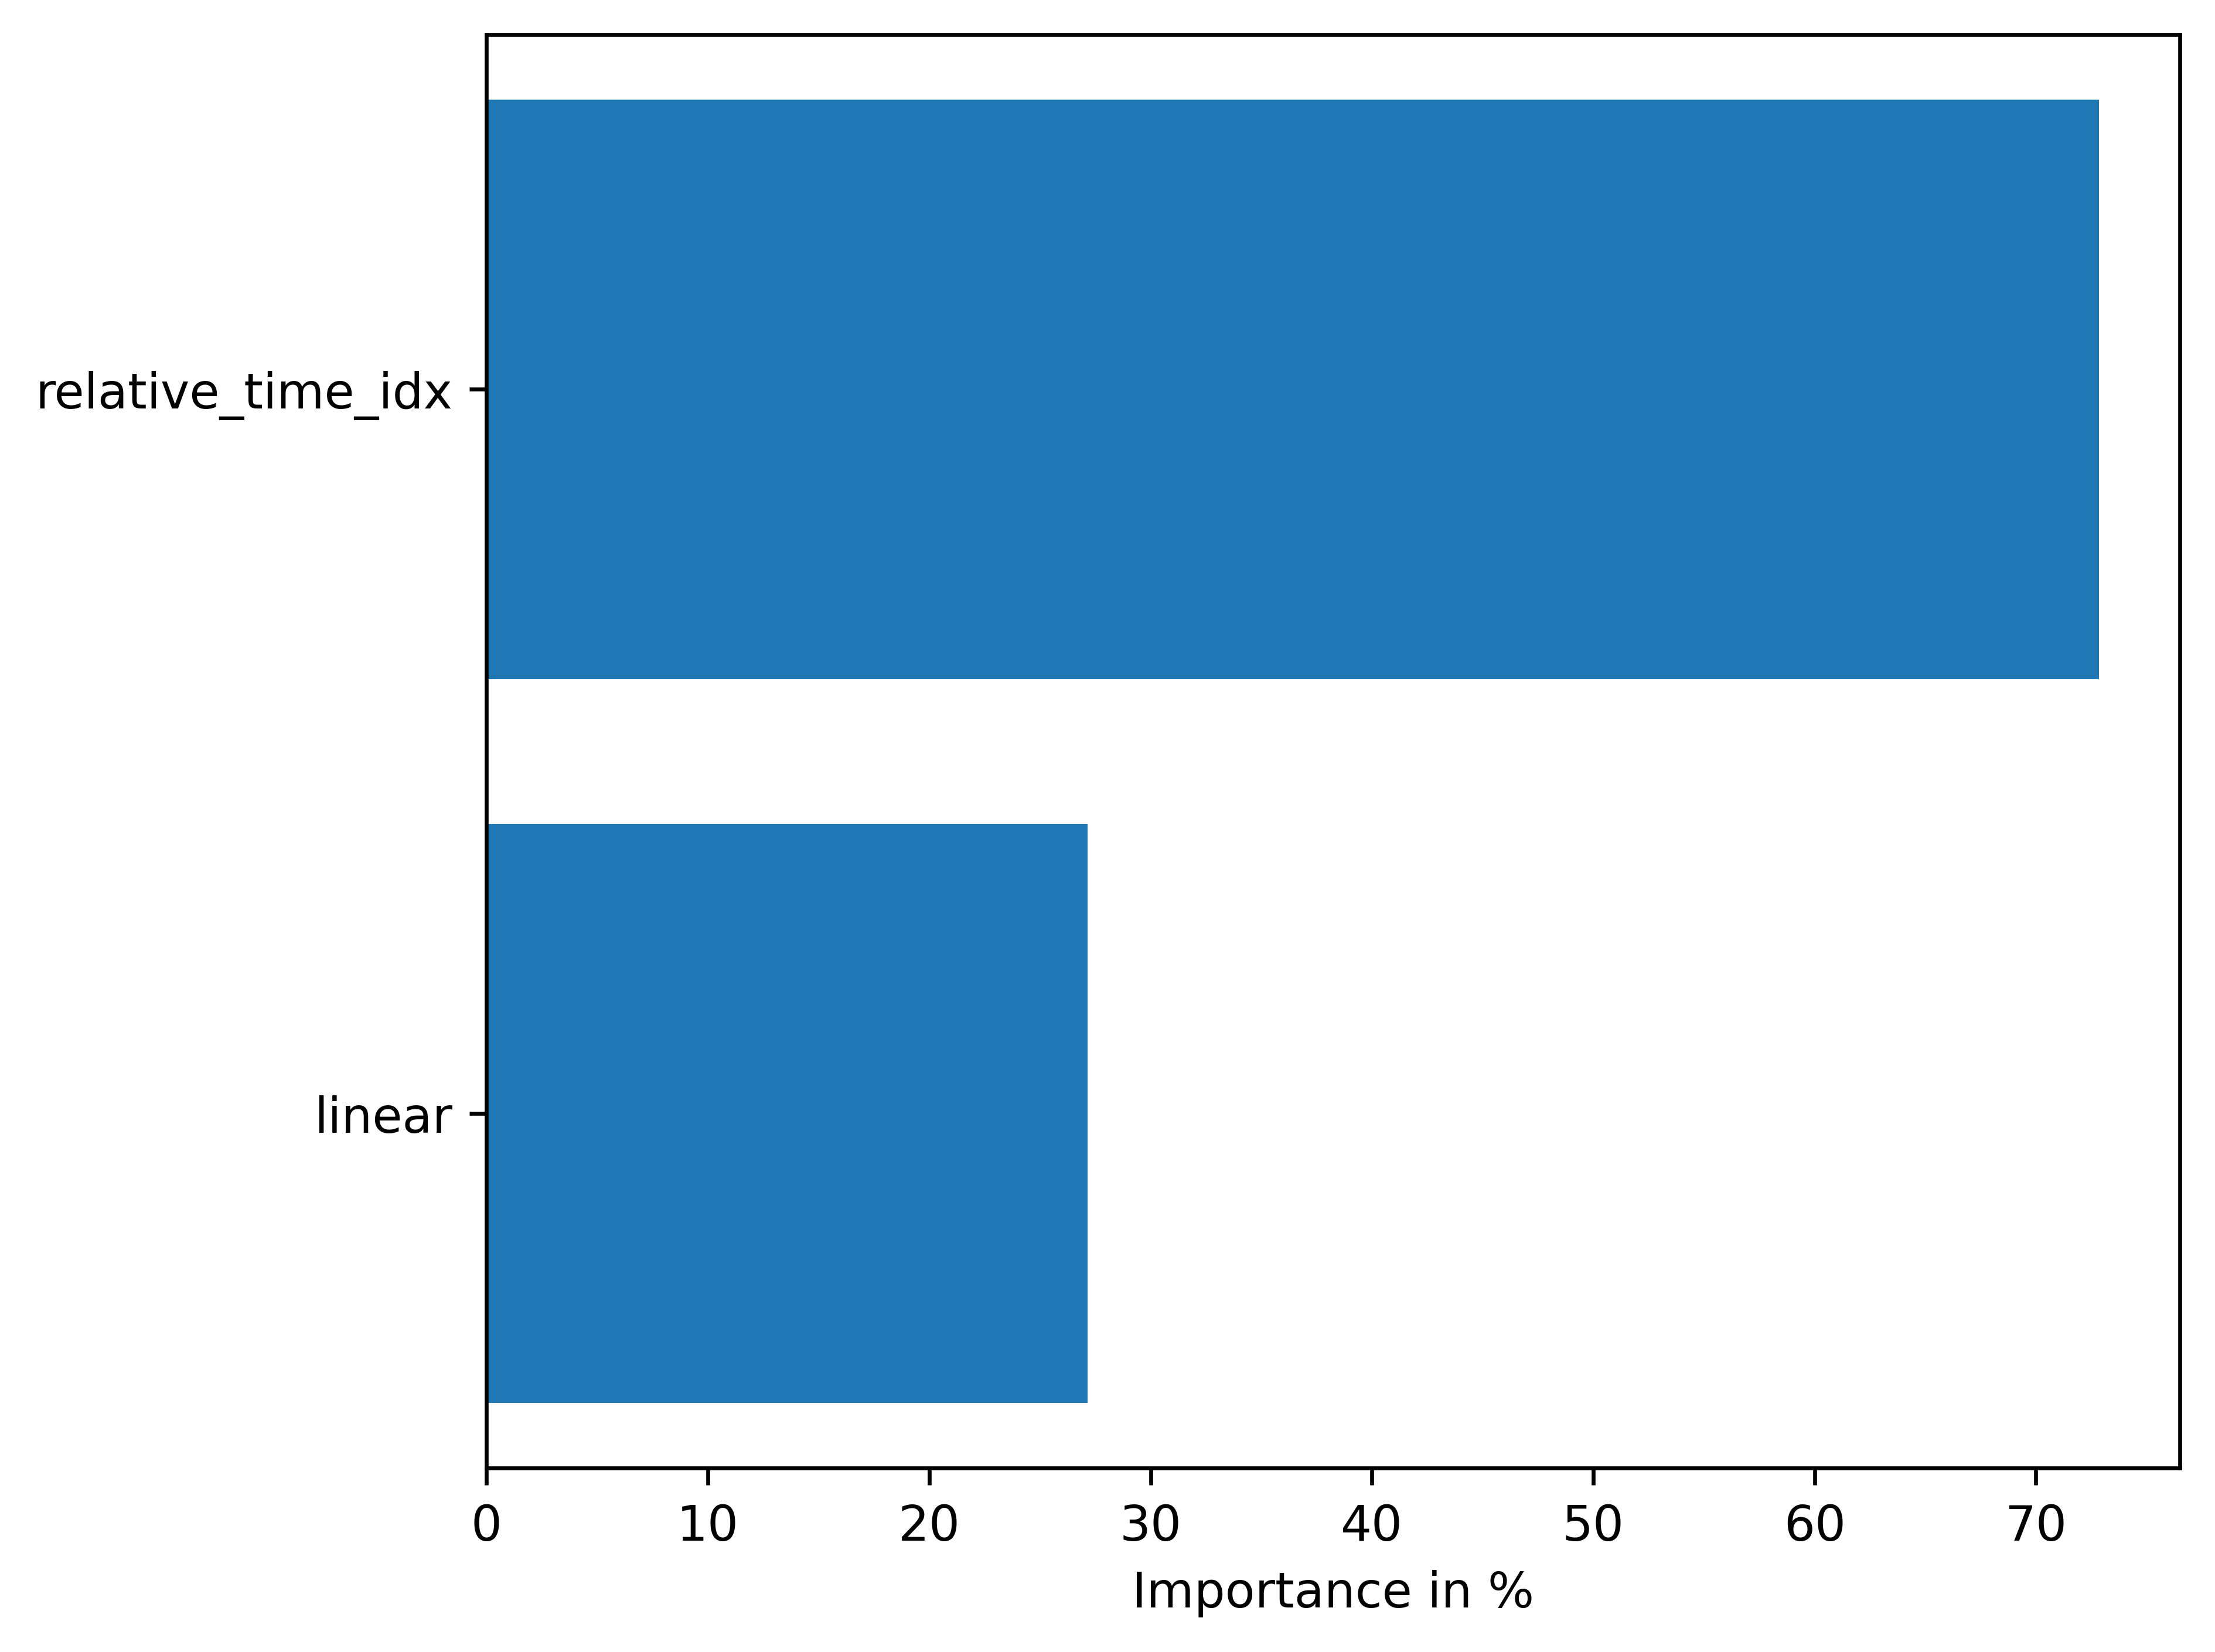

In [79]:
values = interpretation['decoder_variables'].detach().cpu()

order = np.argsort(values)
values = values / values.sum(-1).unsqueeze(-1)
#plt.barh(values,order)
plt.figure(1,dpi=600)
plt.barh(np.arange(len(values)), values[order] * 100, tick_label=np.asarray(best_tft.decoder_variables)[order])
plt.xlabel("Importance in %")
plt.tight_layout()